In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

from utils import vgg

from skimage.transform import resize
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img_gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True, 
    zoom_range=0.15,
)

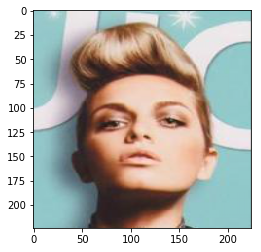

In [3]:
def name(n):
    return "%.6d" % (n+1) + ".jpg"

def pic(n):
    img = plt.imread("./data/img_align_celeba/" + name(n))
    img = resize(img, (224, 224))
    return img

img = pic(4)
plt.imshow(img);

In [4]:
def build_vgg(std=0.02, slope=0.2):
    inp = layers.Input(shape=img.shape)
    init = RandomNormal(stddev=std)
    X = layers.Conv2D(32, 5, strides=(2, 2), padding='same', kernel_initializer=init)(inp)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(64, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(128, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(256, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(512, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(1024, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.Flatten()(X)
    return Model(inp, X)

In [5]:
vgg = build_vgg()
vgg.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
batch_normalization_v2 (Batc (None, 112, 112, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 56, 56, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 64)        0   

In [6]:
def build_critic(rate=0.8):
    origin = layers.Input(shape=img.shape)
    distored = layers.Input(shape=img.shape)
    
    latent_origin = vgg(origin)
    latent_distored = vgg(distored)
    X = layers.Lambda(lambda x: K.abs(x[0]-x[1]))([latent_origin, latent_distored])
    X = layers.Dropout(rate)(X)
    X = layers.Dense(1)(X)
    return Model([origin, distored], X)

In [7]:
critic = build_critic()
critic.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 16384)        17471680    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16384)        0           model_2[1][0]              

In [3]:
def build_encoder(lat_dim=100, slope=0.2, std=0.02, rate=0.8):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=img.shape)

    X = layers.Conv2D(32, 5, strides=(2, 2), padding='same', kernel_initializer=init)(inp)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(64, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(128, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(256, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(512, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(1024, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
   
    X = layers.Flatten()(X)
    X = layers.Dropout(rate=rate)(X)
    X = layers.Dense(lat_dim)(X)
    return Model(inp, X)

In [8]:
# encoder = build_encoder(100)
encoder = tf.keras.models.load_model("encoder.hdf5")
# encoder.summary()

W0413 17:48:43.728919 140178178266944 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [5]:
def build_generator(lat_dim=100, std=0.02):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=(lat_dim,))
    
    X = layers.Dense(14*14*1024, kernel_initializer=init)(inp)
    X = layers.Reshape((14, 14, 1024))(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    X = layers.Conv2DTranspose(512, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    X = layers.Conv2DTranspose(256, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    X = layers.Conv2DTranspose(128, 5, strides=(2, 2), padding="same", kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.ReLU()(X)
    
    X = layers.Conv2DTranspose(3, 5, strides=(2, 2), padding="same", activation="tanh", kernel_initializer=init)(X)
    return Model(inp, X)

In [9]:
# gen = build_generator(100)
gen = tf.keras.models.load_model("gen.hdf5")
# gen.summary()

W0413 17:48:47.256124 140178178266944 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [7]:
def build_lat_discriminator(lat_dim=100, slope=0.2, std=0.02, rate=0.5):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=(lat_dim,))
    
    X = layers.Dense(1024, kernel_initializer=init)(inp)
    X = layers.LeakyReLU(slope)(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Dense(1024, kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.Dropout(rate)(X)
    
    X = layers.Dense(1024, kernel_initializer=init)(X)
    X = layers.LeakyReLU(slope)(X)
    X = layers.Dropout(rate)(X)

    X = layers.Dense(1)(X)
    return Model(inp, X)

In [10]:
# lat_discr = build_lat_discriminator(100)
lat_discr = tf.keras.models.load_model("lat_discr.hdf5")
# lat_discr.summary()

W0413 17:48:49.373638 140178178266944 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [9]:
def build_discriminator(slope=0.2, std=0.02, rate=0.8):
    init = RandomNormal(stddev=std)
    inp = layers.Input(shape=img.shape)

    X = layers.Conv2D(64, 5, strides=(2, 2), padding='same', kernel_initializer=init)(inp)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(128, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(256, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(512, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
    
    X = layers.Conv2D(1024, 5, strides=(2, 2), padding='same', kernel_initializer=init)(X)
    X = layers.BatchNormalization()(X)
    X = layers.LeakyReLU(slope)(X)
   
    X = layers.Flatten()(X)
    X = layers.Dropout(rate=rate)(X)
    X = layers.Dense(1)(X)
    return Model(inp, X)

In [11]:
# discr = build_discriminator()
discr = tf.keras.models.load_model("discr.hdf5")
# discr.summary()

W0413 17:48:52.031497 140178178266944 hdf5_format.py:224] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [12]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cosine = tf.keras.losses.CosineSimilarity()

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.ids = np.arange(200_000)
        self.on_epoch_end()
        
    def __getitem__(self, index):
        ids = self.ids[self.batch_size * index : self.batch_size * (index + 1)]
        X_origin = np.empty((self.batch_size, *img.shape), dtype=np.float32)
        X_distored = np.empty((self.batch_size, *img.shape), dtype=np.float32)
        for i, _id in enumerate(ids):
            X_origin[i] = pic(_id)
            X_distored[i] = img_gen.random_transform(X_origin[i])
        return X_origin, X_distored
    
    def __len__(self):
        return len(self.ids) // self.batch_size
    
    def on_epoch_end(self):
        np.random.shuffle(self.ids)

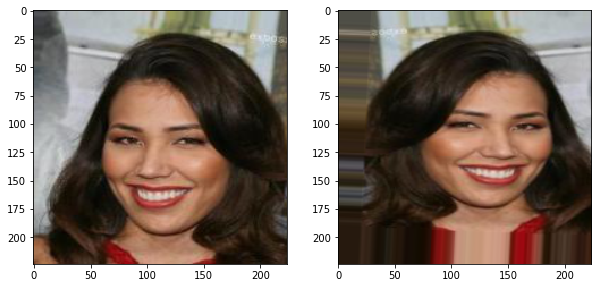

In [14]:
data = DataGenerator(1)
x, y = data[0]
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(x[0])
plt.subplot(122)
plt.imshow(y[0]);

In [15]:
lat_dim = 100
l_rate = 0.00005
b1 = 0.6

enc_opt = tf.keras.optimizers.Adam(l_rate, b1)
lat_discr_opt = tf.keras.optimizers.Adam(l_rate, b1)
gen_opt = tf.keras.optimizers.Adam(l_rate, b1)
discr_opt = tf.keras.optimizers.Adam(l_rate, b1)
critic_opt = tf.keras.optimizers.Adam(l_rate, b1)


batch_size = 32

@tf.function
def train_step(real_images, distored_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape, \
        tf.GradientTape() as enc_tape, tf.GradientTape() as ldiscr_tape, tf.GradientTape() as critic_tape:
        
        encoded = encoder(real_images, training=True)
        noise = tf.random.normal(shape=[batch_size, lat_dim])

        reconstructed = gen(encoded, training=True)
        fake_images = gen(noise, training=True)
        
        noise_codes_output = lat_discr(noise, training=True)
        real_codes_output = lat_discr(encoded, training=True)
        
        fake_output = discr(fake_images, training=True)
        real_output = discr(real_images, training=True)
        reconstructed_output = discr(reconstructed, training=True)
        
        critic_reconstructed = critic([real_images, reconstructed], training=True)
        critic_distored = critic([real_images, distored_images], training=True)
        
        # (origin, distored) -> 1, (origin, reconstructed) -> 0
        critic_loss = entropy(0.95*tf.ones_like(critic_distored), critic_distored) + \
                      entropy(tf.zeros_like(critic_reconstructed), critic_reconstructed)
        
        # critic(origin, reconstructed) -> 1
        reconstructed_loss = entropy(tf.ones_like(critic_reconstructed), critic_reconstructed)
        
        enc_loss = reconstructed_loss + entropy(tf.ones_like(real_codes_output), real_codes_output)
        
        # fake_output -> 1, reconstructed_output -> 1
        gen_loss = reconstructed_loss + entropy(tf.ones_like(fake_output), fake_output) + \
                    entropy(tf.ones_like(reconstructed_output), reconstructed_output)
        
        # real_output -> 1, fake_output -> 0, reconstructed_output -> 0
        discr_loss = entropy(0.95*tf.ones_like(real_output), real_output) + \
                         entropy(tf.zeros_like(fake_output), fake_output) + \
                         entropy(tf.zeros_like(reconstructed_output), reconstructed_output)
        
        lat_discr_loss = entropy(0.95*tf.ones_like(noise_codes_output), noise_codes_output) + \
                         entropy(tf.zeros_like(real_codes_output), real_codes_output)

        gen_grads = gen_tape.gradient(gen_loss, gen.trainable_variables)
        lat_discr_grads = ldiscr_tape.gradient(lat_discr_loss, lat_discr.trainable_variables)
        enc_grads = enc_tape.gradient(enc_loss, encoder.trainable_variables)
        discr_grads = discr_tape.gradient(discr_loss, discr.trainable_variables)
        critic_grads = critic_tape.gradient(critic_loss, critic.trainable_variables)

    gen_opt.apply_gradients(zip(gen_grads, gen.trainable_variables))
    lat_discr_opt.apply_gradients(zip(lat_discr_grads, lat_discr.trainable_variables))
    enc_opt.apply_gradients(zip(enc_grads, encoder.trainable_variables))
    discr_opt.apply_gradients(zip(discr_grads, discr.trainable_variables))
    critic_opt.apply_gradients(zip(critic_grads, critic.trainable_variables))
    
    return gen_loss, lat_discr_loss, enc_loss, discr_loss, critic_loss

In [16]:
def generate_images(gen, encoder, n):
    x = pic(n).reshape((1, *img.shape))
    real_code = encoder.predict(x)
    code = tf.random.normal(shape=[1, lat_dim])
    _x = gen.predict(code)
    _img = gen(code)
    fig = plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.imshow(_img[0, :, :])
    plt.axis('off')
    plt.subplot(122)
    _img = gen(real_code)
    plt.imshow(_img[0, :, :])
    plt.axis('off')
    plt.show()

W0413 20:01:40.240345 140178178266944 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0413 20:01:40.263835 140178178266944 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


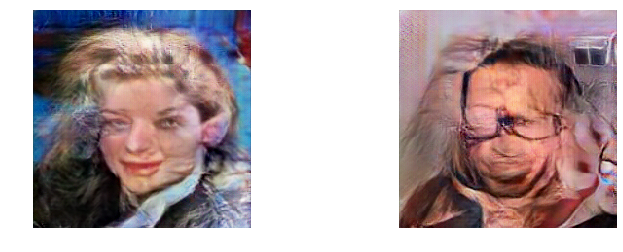

E-1 I-781 tf.Tensor(14.380172, shape=(), dtype=float32):tf.Tensor(0.4522192, shape=(), dtype=float32):tf.Tensor(6.9955387, shape=(), dtype=float32):tf.Tensor(0.5605683, shape=(), dtype=float32)tf.Tensor(0.37411636, shape=(), dtype=float32)


In [ ]:
epochs = 10
data = DataGenerator(batch_size)

for epoch in range(1, epochs + 1):
    for i, (origin, distored) in enumerate(data):
        gl, ldl, el, dl, cl = train_step(origin, distored)
        if i % 10 == 0:
            display.clear_output(wait=True)
            generate_images(gen, encoder, 4)
            print("E-%d I-%d %s:%s:%s:%s%s" % (epoch, (i+1), str(gl), str(dl), str(el), str(ldl), str(cl)))

W0413 19:20:36.984542 140178178266944 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


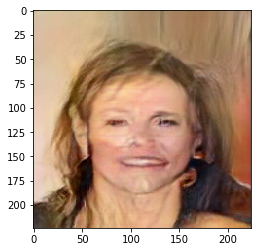

In [19]:
plt.imshow(gen.predict(np.random.normal(size=(1, lat_dim))).reshape((img.shape)));

W0413 19:21:36.182567 140178178266944 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


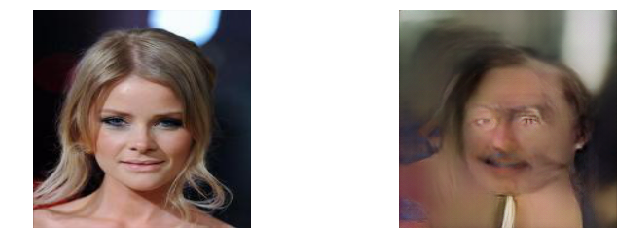

In [29]:
idx = 9

vec1 = encoder.predict(pic(idx).reshape(1, *img.shape))
_img = gen.predict(vec1).reshape(*img.shape)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(pic(idx))
plt.axis('off')
plt.subplot(122)
plt.imshow(_img)
plt.axis('off');

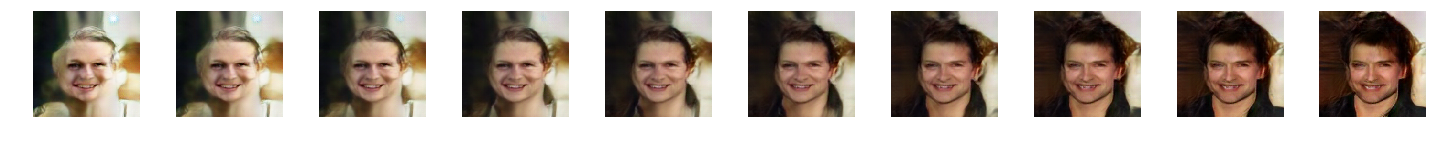

In [30]:
vec1 = np.random.normal(size=([1, lat_dim]))
vec2 = np.random.normal(size=([1, lat_dim]))
alpha = np.arange(0, 1., 0.1)

plt.figure(figsize=(20, 10))
for i, a in enumerate(alpha):
    plt.subplot(1, len(alpha), i+1)
    vec = a * vec1 + (1-a) * vec2
    _img = gen.predict(vec).reshape(*img.shape)
    _img[_img < 0] = 0
    plt.imshow(_img)
    plt.axis('off')
plt.tight_layout();

In [96]:
gen.save("gen.hdf5")
discr.save("discr.hdf5")
encoder.save("encoder.hdf5")
lat_discr.save("lat_discr.hdf5")